In [1]:
#读取h5 文件
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import sys
from numba import jit
import seaborn as sns
from mylab.ana.miniscope.Mquality import *
from mylab.ana.miniscope.Mgraph import *

# f = h5py.File(r"aCA3_shock_activated_.h5")
f = h5py.File(r"aCA3_all_cells_.h5")


# time_points,cell_id
preA = np.array(f["preA"]) # 165,100
# preA_cor = np.corrcoef(preA) # 165,165
preA2 = np.array(f["preA2"])# 165,100
preA2_cor = np.corrcoef(preA2)
preB = np.array(f["preB"]) # 165,100
# preB_cor = np.corrcoef(preB)
preB2 = np.array(f["preB2"])# 165,100
# preB2_cor = np.corrcoef(preB2)

    

<ipython-input-1-9f077bf3855b>:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(r"aCA3_all_cells_.h5")
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [36]:
matrix = pd.DataFrame(np.corrcoef(np.array(f["preA"])))

g = make_graph(matrix,threshold=0.7)
g.plot()

C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


shuffle for 1000/1000 times 
H0: two sampls are similarily distributed: 
**** p-value: 1.224176301023092e-39


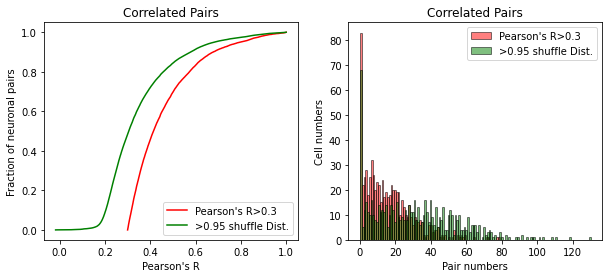

In [3]:
correlated_pair_threshold(preA,0.3)

C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


shuffle for 1000/1000 times 
check whether two sampls are similarily distributed: 
**** p-value: 9.170572555570356e-10


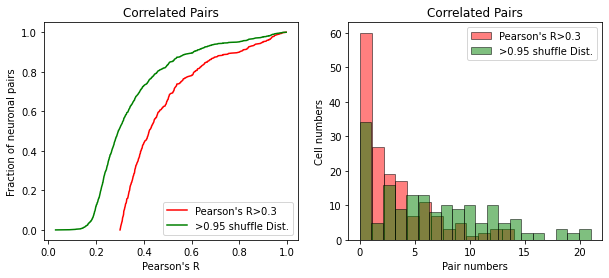

In [75]:
correlated_pair_threshold(preA2,0.3)

C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


shuffle for 1000/1000 times 


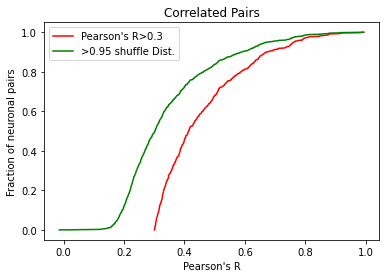

In [670]:
correlated_pair_threshold(preB,0.3)

C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\qiushou\.conda\envs\mylab\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


shuffle for 1000/1000 times 


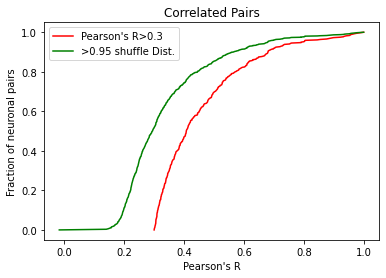

In [671]:
correlated_pair_threshold(preB2,0.3)

You did not provide a neuron position dictionary. The spring layout function will be used to plot the network


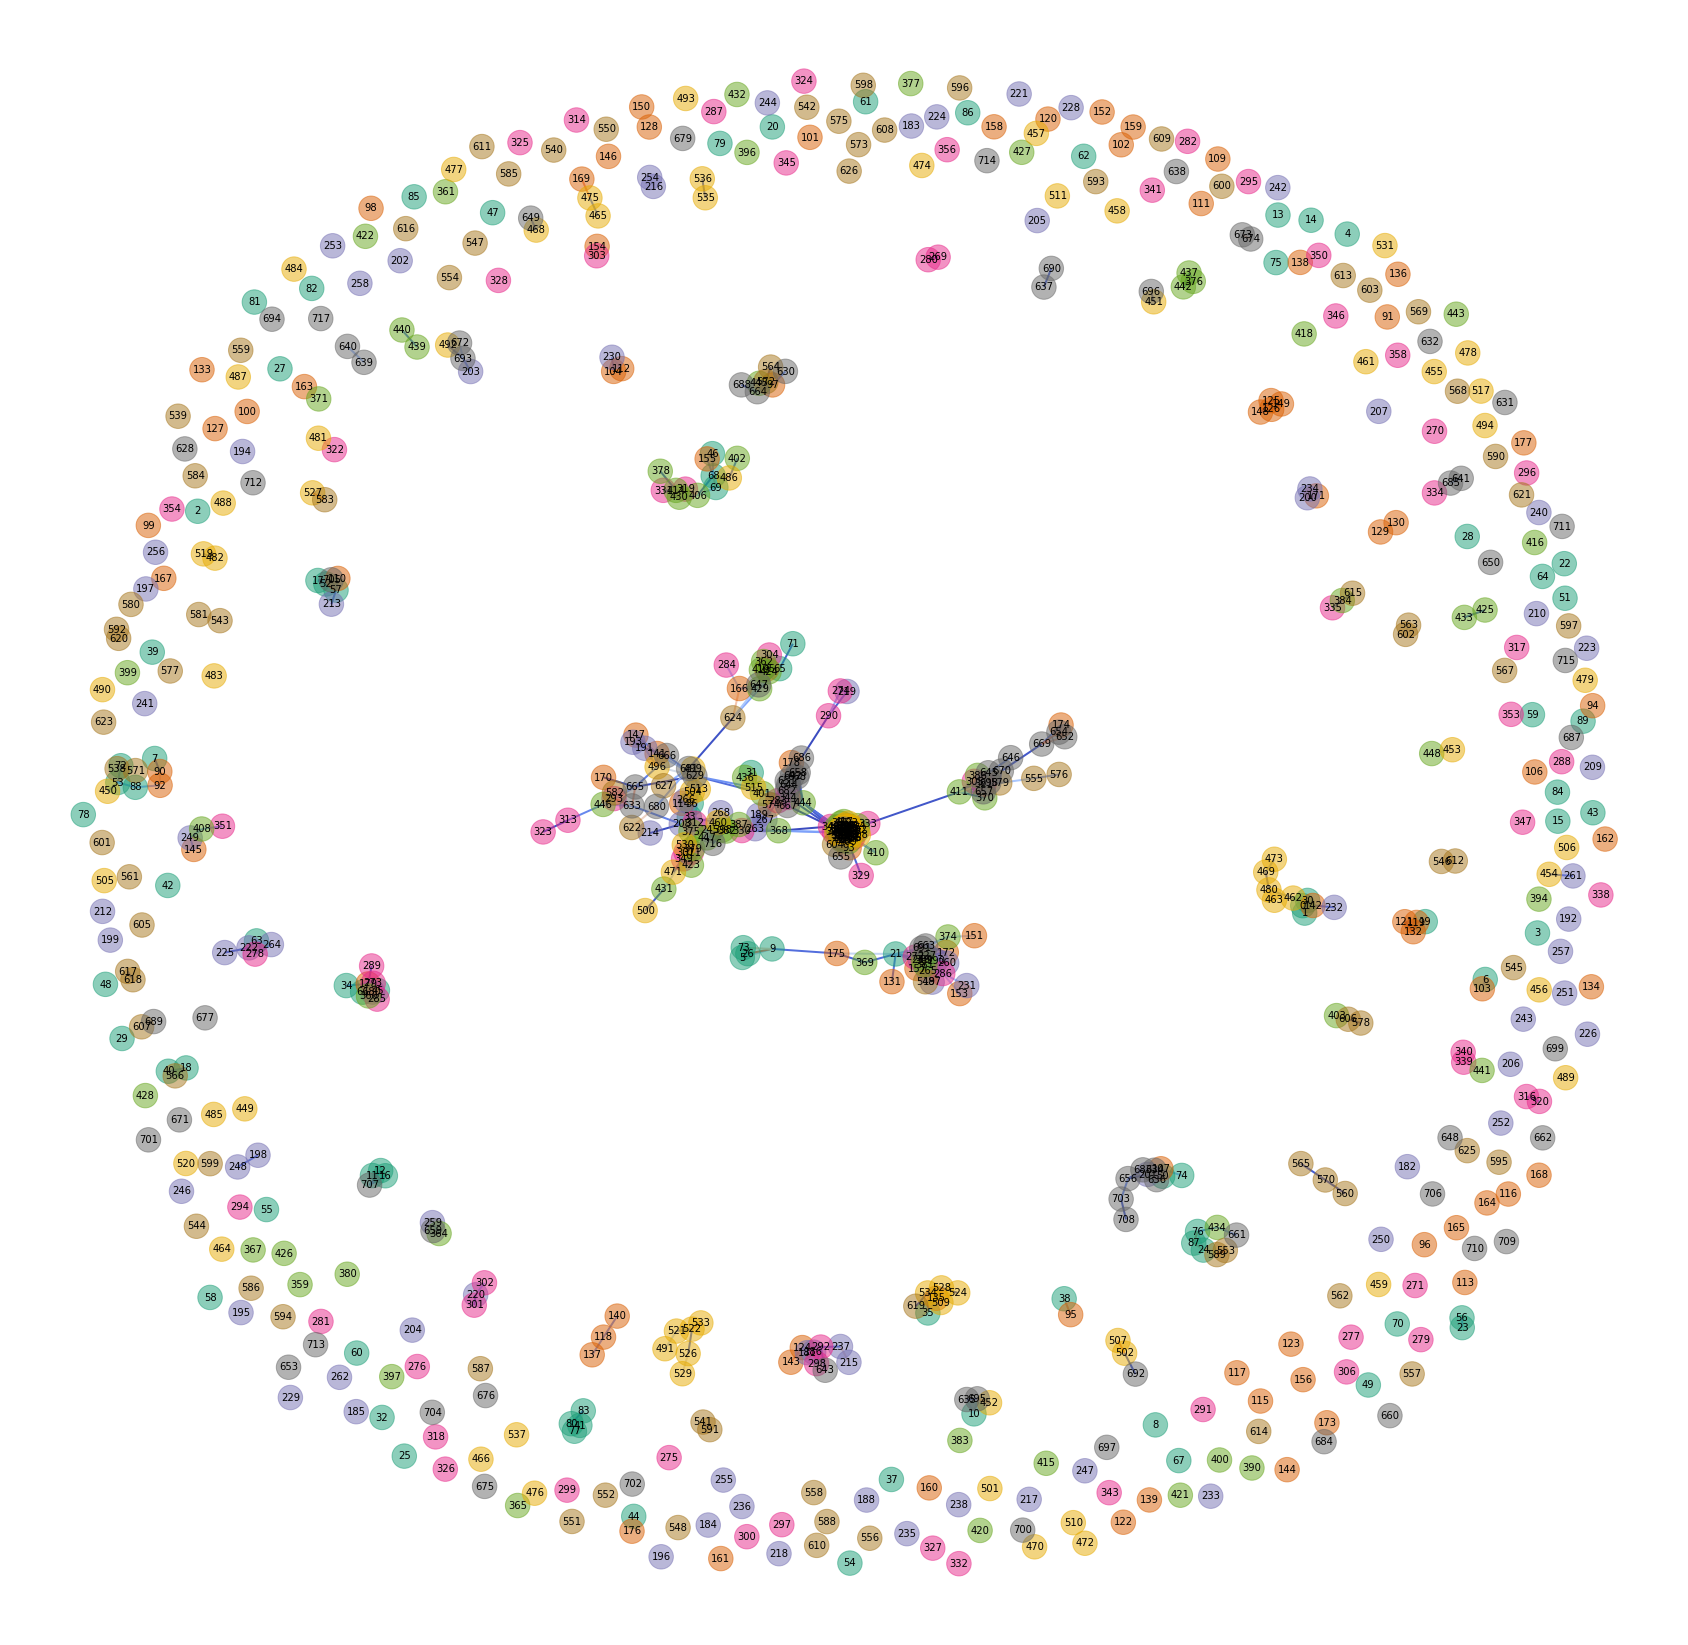

{0: array([ 0.59277773, -0.10610031]),
 1: array([ 0.59527886, -0.11604793]),
 2: array([-0.85057682,  0.42148554]),
 3: array([ 0.89931405, -0.14262913]),
 4: array([0.65079552, 0.79218102]),
 5: array([-0.13924043, -0.17532465]),
 6: array([ 0.83104706, -0.20481417]),
 7: array([-0.90674984,  0.09075582]),
 8: array([ 0.40025786, -0.80057257]),
 9: array([-0.10038189, -0.16394649]),
 10: array([ 0.1633452, -0.7858361]),
 11: array([-0.62232095, -0.46706828]),
 12: array([-0.61157513, -0.46041337]),
 13: array([0.56035972, 0.81763923]),
 14: array([0.60359454, 0.81074309]),
 15: array([0.9259032 , 0.00694116]),
 16: array([-0.60547435, -0.46737239]),
 17: array([-0.6935522 ,  0.32887015]),
 18: array([-0.86578763, -0.3231222 ]),
 19: array([ 0.75275499, -0.12746669]),
 20: array([-0.10002382,  0.93552095]),
 21: array([ 0.06098003, -0.17068449]),
 22: array([0.93431681, 0.35132572]),
 23: array([ 0.80104041, -0.67047244]),
 24: array([ 0.46295145, -0.56677812]),
 25: array([-0.5807511

In [16]:
g = make_graph(pd.DataFrame(preA2_cor),0.7)
g.plot()


### correlated pair ratio
**Significantly correlated pairs of neurons** were defined based on
the correlation coefficients of Ca2+ transient events within one
second time bins during context exploration
$$The\ correlated\ pair\ ratio =\frac{\#pairs}{\#total\ cells}$$


`R thresholds at p < 0.05 from the shuffle distribution were then applied to determine the number of correlated pairs with shuffled R thresholds(Jimenez et al. 2020)`


            
        
### component probability
A connected component is defined as a subgraph of nodes connected to each other by paths but not
connected to any other nodes. **Each neuron was assigned either a 0 or 1 indicating
whether it was a component member**, and the proportion of neurons in a component (component probability) was computed for each imaging session

correlated function in module `Mgraph.py`
`frac_nodes_in_component(g,threshold)`
**threshold** means the minimum component size.
`Due to the sparse nature of these neural graphs, we also determined whether each neuron was as member of a connected component containing at least two other neurons(Jimenez et al. 2020)`which means threshold in this paper is **3**.
$$Component\ probability =\frac{\#\ neurons\  in\  a\ component}{\#neurons\ in\  session}$$

### clustering coefficient
 the
extent to which a given neuron’s pairs were also correlated with
each other (clustering coefficient)
$$Clustering\ coefficient =\frac{\# edges\ among\ neighbors}{\# possible\ edges\ among neighbors} $$

`Connection density is the actual number of edges in the graph as a            proportion of the total number of possible edges and is the simplest            estimator of the physical cost — for example, the energy or other resource requirements — of a network. (Bullmore et al. 2009)`

Total number of possible edges is: n(n-1)/2,where n is the number of nodes (neurons) in the graph.

correlated function in class NeuronalNetwork: `self.compute_connection_density()`

In [18]:
g.compute_connection_density()

0.005971181377062427

In [57]:
np.corrcoef? 

In [56]:
np.cov?